In [1]:
import pandas as pd
import itertools
import time
import multiprocessing
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

pd.options.mode.chained_assignment = None
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
#sns.set(rc={'figure.figsize':(10,10)})
import matplotlib
#matplotlib.use('agg')
#matplotlib.style.use('ggplot')
import pickle as pkl
from matplotlib import pyplot as plt
#plt.rcParams.update(plt.rcParamsDefault)
new_plot_col=list(range(1900,2001,10))
from scipy.stats.stats import pearsonr
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

In [2]:
def year_binner(year,val=10):
    return year - year%val

In [3]:
def lemma_maker(x, y):
    #print(lemmatizer(x,y)[0])
    return lemmatizer(x,y)[0]

In [4]:
br_to_us=pd.read_excel("Book.xlsx",skiprows=[0])
br_to_us_dict=dict(zip(br_to_us.UK.tolist(),br_to_us.US.tolist()))
spelling_replacement={'modifier':br_to_us_dict,'head':br_to_us_dict}

## Reddy Dataset

In [5]:
reddy11_study=pd.read_csv("/data/dharp/compounding/datasets/ijcnlp_compositionality_data/MeanAndDeviations.clean.txt",sep="\t")
#print(reddy11_study.columns)
reddy11_study.columns=['compound','to_divide']
reddy11_study['modifier_mean'],reddy11_study['modifier_std'],reddy11_study['head_mean'],reddy11_study['head_std'],reddy11_study['compound_mean'],reddy11_study['compound_std'],_=reddy11_study.to_divide.str.split(" ",7).str
reddy11_study['modifier'],reddy11_study['head']=reddy11_study['compound'].str.split(" ",2).str
reddy11_study.modifier=reddy11_study.modifier.str[:-2]
reddy11_study['head']=reddy11_study['head'].str[:-2]
reddy11_study.drop(['compound','to_divide'],axis=1,inplace=True)
reddy11_study['modifier']=np.vectorize(lemma_maker)(reddy11_study['modifier'],'noun')
reddy11_study['head']=np.vectorize(lemma_maker)(reddy11_study['head'],'noun')
reddy11_study.replace(spelling_replacement,inplace=True)
reddy11_study['modifier']=reddy11_study['modifier']+"_noun"
reddy11_study['head']=reddy11_study['head']+"_noun"
reddy11_study=reddy11_study.apply(pd.to_numeric, errors='ignore')
#reddy11_study.set_index(['modifier','head'],inplace=True)
reddy11_study.info()
reddy11_study.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
modifier_mean    90 non-null float64
modifier_std     90 non-null float64
head_mean        90 non-null float64
head_std         90 non-null float64
compound_mean    90 non-null float64
compound_std     90 non-null float64
modifier         90 non-null object
head             90 non-null object
dtypes: float64(6), object(2)
memory usage: 5.7+ KB


,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.867,1.118,4.867,0.340,4.250,0.871,end_noun,user_noun
1,1.607,1.655,1.893,1.496,1.704,1.717,firing_noun,line_noun
2,2.821,1.965,4.862,0.345,3.828,1.234,game_noun,plan_noun
3,4.767,0.423,4.862,0.345,4.800,0.476,application_noun,form_noun
4,0.600,0.800,4.586,1.099,1.310,1.021,snail_noun,mail_noun


## Compounds Dataset

In [6]:
compounds=pd.read_pickle("/data/dharp/compounding/datasets/compounds.pkl")
compounds.reset_index(inplace=True)
compounds.year=compounds.year.astype("int32")
compounds=compounds.query('1800 <= year <= 2010').copy()
compounds['time']=np.vectorize(year_binner)(compounds['year'],10)
compounds=compounds.groupby(['modifier','head','context','time'])['count'].sum().to_frame()
compounds.reset_index(inplace=True)
compounds.info()
compounds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58475145 entries, 0 to 58475144
Data columns (total 5 columns):
modifier    object
head        object
context     object
time        int64
count       float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.2+ GB


,modifier,head,context,time,count
0,a_noun,aaaaa_noun,a_noun,1870,1.000
1,a_noun,aaaaa_noun,a_noun,1910,1.000
2,a_noun,aaaaa_noun,a_noun,1920,3.000
3,a_noun,aaaaa_noun,a_noun,1930,1.000
4,a_noun,aaaaa_noun,a_noun,1940,1.000


In [7]:
modifiers=pd.read_pickle("/data/dharp/compounding/datasets/modifiers.pkl")
modifiers.reset_index(inplace=True)
modifiers.year=modifiers.year.astype("int32")
modifiers=modifiers.query('1800 <= year <= 2010').copy()
modifiers['time']=np.vectorize(year_binner)(modifiers['year'],10)
modifiers=modifiers.groupby(['modifier','context','time'])['count'].sum().to_frame()
modifiers.reset_index(inplace=True)

modifiers.info()
modifiers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35305741 entries, 0 to 35305740
Data columns (total 4 columns):
modifier    object
context     object
time        int64
count       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ GB


,modifier,context,time,count
0,a_noun,'_noun,1820,1.000
1,a_noun,'_noun,1830,5.000
2,a_noun,'_noun,1840,7.000
3,a_noun,'_noun,1850,3.000
4,a_noun,'_noun,1870,12.000


In [8]:
heads=pd.read_pickle("/data/dharp/compounding/datasets/heads.pkl")
heads.reset_index(inplace=True)
heads.year=heads.year.astype("int32")
heads=heads.query('1800 <= year <= 2010').copy()
heads['time']=np.vectorize(year_binner)(heads['year'],10)
heads=heads.groupby(['head','context','time'])['count'].sum().to_frame()
heads.reset_index(inplace=True)

heads.info()
heads.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39037008 entries, 0 to 39037007
Data columns (total 4 columns):
head       object
context    object
time       int64
count      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ GB


,head,context,time,count
0,a_noun,'_noun,1860,2.000
1,a_noun,'_noun,1870,4.000
2,a_noun,'_noun,1880,3.000
3,a_noun,'_noun,1890,12.000
4,a_noun,'_noun,1900,23.000


## Semantic Feature Calculations

In [9]:
compound_decade_counts=compounds.groupby(['time'])['count'].sum().to_frame()
compound_decade_counts.columns=['N']
compound_decade_counts

,N
time,
1800,"2,221,799.000"
1810,"3,734,437.000"
1820,"5,918,761.000"
1830,"8,585,110.000"
1840,"11,371,679.000"
1850,"18,577,463.000"
1860,"16,592,705.000"
1870,"20,537,209.000"
1880,"30,681,942.000"


In [10]:
XY=compounds.groupby(['modifier','head','time'])['count'].sum().to_frame()
XY.columns=['a']
X_star=compounds.groupby(['modifier','time'])['count'].sum().to_frame()
X_star.columns=['x_star']
Y_star=compounds.groupby(['head','time'])['count'].sum().to_frame()
Y_star.columns=['star_y']
merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])
information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])
information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']
information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['time'])
information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']
#information_feat['LR']=-2*np.sum(information_feat['a']*np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y'])))
information_feat.set_index(['modifier','head','time'],inplace=True)
information_feat.replace(0,0.001,inplace=True)
information_feat['log_ratio']=2*(information_feat['a']*np.log((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))+\
information_feat['b']*np.log((information_feat['b']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y_bar']))+\
information_feat['c']*np.log((information_feat['c']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y']))+\
information_feat['d']*np.log((information_feat['d']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y_bar'])))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat

log_ratio   ppmi  local_mi
modifier          head              time                            
a_noun            aaaaa_noun        1870     18.928 13.663    13.663
                  b_noun            1870 11,305.823  9.926 8,933.260
afterward_noun    b_noun            1870     42.820  8.933    35.733
all_noun          b_noun            1870     17.894  5.696    17.088
angle_noun        b_noun            1870 10,915.169  8.890 9,050.495
appendix_noun     b_noun            1870  1,474.323  8.203 1,263.287
application_noun  b_noun            1870     15.237  5.049    15.148
area_noun         b_noun            1870     76.475  4.828    77.242
arm_noun          b_noun            1870      2.823  1.666     4.999
arrow_noun        b_noun            1870     15.917  4.229    16.915
article_noun      b_noun            1870     15.210  2.801    19.604
astonishment_noun b_noun            1870     55.244  7.968    47.808
attribute_noun    b_noun            1870    100.951  6.588    92.230
avenue_noun       b_noun            1870      8.118  4.289     8.579
axi_noun          b_noun            1870     27.719  5.390    26.950
b_noun            b_noun            1870  1,229.723  5.085 1,215.198
ball_noun         b_noun            1870    238.738  6.763   216.423
bank_noun         b_noun            1870      8.339  0.988    21.746
bar_noun          b_noun            1870      3.993  1.726     6.903
base_noun         b_noun            1870     27.216  2.020    42.425
battery_noun      b_noun            1870    593.077  6.930   533.647
beam_noun         b_noun            1870     28.000  4.744    28.466
bed_noun          b_noun            1870     12.224  3.026    15.131
boat_noun         b_noun            1870     39.396  3.496    45.451
body_noun         b_noun            1870    167.907  3.469   194.239
book_noun         b_noun            1870      1.200  0.000    -1.979
breadth_noun      b_noun            1870    150.162  4.994   149.810
bulb_noun         b_noun            1870    803.708  6.795   727.022
buoyancy_noun     b_noun            1870    238.234 10.741   171.848
c_noun            b_noun            1870  9,984.989  8.092 8,520.763
...                                             ...    ...       ...
zemmery_noun      fidd_noun         1900    172.823 23.495   117.476
zemsky_noun       sobor_noun        1900    331.814 22.495   224.953
zend_noun         avesta_noun       1900  2,698.095 19.263 1,810.684
zeno_noun         practising_noun   1900     37.763 25.817    25.817
zeu_noun          eleutherio_noun   1900    968.385 16.972   695.839
                  herkeio_noun      1900    731.478 16.972   526.123
                  lykaio_noun       1900    471.418 16.972   339.434
                  olympio_noun      1900    542.288 16.972   390.349
                  phratrio_noun     1900    235.478 16.972   169.717
                  polieu_noun       1900    235.478 16.972   169.717
zeventiende_noun  eeuw_noun         1900    269.015 22.817   182.537
zila_noun         parishad_noun     1900    724.902 21.294   489.753
zilia_noun        moncada_noun      1900  1,159.529 20.569   781.632
zilver_noun       zixpence_noun     1900     72.777 24.817    49.634
zinc_noun         blende_noun       1900  1,234.358 11.269   890.229
                  methyl_noun       1900     46.850 11.269    33.806
zona_noun         arcuata_noun      1900    242.332 17.460   174.596
                  fasciculata_noun  1900    315.158 17.460   226.975
                  glomerulosa_noun  1900    680.158 17.460   488.870
                  pectinata_noun    1900    242.332 17.460   174.596
                  reticulari_noun   1900     96.849 17.460    69.839
zone_noun         flung_noun        1900    290.214 17.421   209.047
zoo_noun          pottet_noun       1900    300.525 22.647   203.825
zoon_noun         politikon_noun    1900    172.823 23.495   117.476
zulu_noun         kaffirland_noun   1900    421.061 16.849   303.273
                  kafir_noun        1900

In [11]:
modifier_decade_counts=modifiers.groupby(['time'])['count'].sum().to_frame()
modifier_decade_counts.columns=['N']
modifier_decade_counts

,N
time,
1800,"4,260,299.000"
1810,"7,081,828.000"
1820,"11,146,815.000"
1830,"16,308,508.000"
1840,"21,798,635.000"
1850,"35,082,609.000"
1860,"31,520,927.000"
1870,"39,222,061.000"
1880,"58,133,022.000"


In [12]:
head_decade_counts=heads.groupby(['time'])['count'].sum().to_frame()
head_decade_counts.columns=['N']
head_decade_counts

,N
time,
1800,"4,418,242.000"
1810,"7,356,191.000"
1820,"11,626,023.000"
1830,"16,933,632.000"
1840,"22,571,765.000"
1850,"36,444,212.000"
1860,"32,702,895.000"
1870,"40,605,657.000"
1880,"60,222,590.000"


In [13]:
modifier_denom=modifiers.groupby(['modifier','time'])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
modifier_denom.columns=['modifier_denom']
modifier_denom

modifier_denom
modifier       time                
a_noun         1800          48.477
               1810          84.232
               1820          96.825
               1830         177.609
               1840         303.322
               1850         602.050
               1860         693.748
               1870         971.157
               1880       1,669.466
               1890       2,725.911
               1900       3,354.415
               1910       3,262.388
               1920       3,166.047
               1930       2,826.234
               1940       1,956.270
               1950       2,135.754
               1960       2,986.450
               1970       3,493.183
               1980       4,783.397
               1990       8,438.250
               2000      13,718.145
aa_noun        1800          12.530
               1810          71.056
               1820          36.742
               1830          14.933
               1840           2.000
               1850           5.657
               1860          10.100
               1870          21.048
               1880          18.466
...                             ...
zymogen_noun   1950         127.024
               1960         300.826
               1970         455.428
               1980         480.968
               1990         133.581
               2000         119.825
zymomona_noun  1970           1.000
               1980          23.000
               1990           9.000
               2000          11.000
zymophore_noun 1900          11.000
               1910          45.000
               1920          13.000
               1930           5.000
               2000           1.000
zymosan_noun   1950          12.000
               1960          33.000
               1970           4.000
               1980           7.000
               1990           1.000
               2000           1.000
zz_noun        1950           2.000
               1960           4.000
               1970          13.454
               1980          32.357
               1990          50.269
               2000          84.593
zzzz_noun      1980          14.422
               1990         155.039
               2000         352.795

[863425 rows x 1 columns]

In [ ]:
head_denom=heads.groupby(['head',"time"])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
head_denom.columns=['head_denom']
head_denom

head_denom
head            time            
a_noun          1800     388.363
                1810     749.507
                1820   1,024.075
                1830     828.832
                1840     860.215
                1850   1,088.901
                1860   1,108.846
                1870   1,852.146
                1880   2,615.238
                1890   3,275.432
                1900   4,563.623
                1910   5,722.844
                1920   7,834.109
                1930   9,586.097
                1940  11,963.402
                1950  25,051.102
                1960  37,209.555
                1970  52,359.226
                1980  69,050.640
                1990  94,904.949
                2000 123,205.908
aa_noun         1800      27.074
                1810      50.931
                1820      75.789
                1830      29.496
                1840      40.509
                1850     116.525
                1860      33.091
                1870      73.423
                1880      81.142
...                          ...
zworykin_noun   2000      95.263
zydom_noun      1980       5.657
                1990      35.355
                2000      33.941
zygmunt_noun    1990      30.887
                2000      66.310
zygomycete_noun 1970       5.657
                1980      14.142
                1990      25.456
                2000      24.042
zygote_noun     1980      25.000
                1990     119.256
                2000     211.197
zylberman_noun  1970       9.899
                1980      60.811
                1990     103.238
                2000     128.693
zymelman_noun   1960       8.485
                1970       9.899
                1980     136.854
                1990      41.012
                2000      15.556
zysman_noun     1980   1,122.279
                1990   1,649.385
                2000     780.399
zytko_noun      1960       1.732
                1970      86.603
                2000       1.732
zywicki_noun    1980      15.588
                1990      62.354

[1077238 rows x 1 columns]

In [ ]:
compound_denom=compounds.groupby(['modifier','head',"time"])['count'].agg(lambda x: np.sqrt(np.sum(np.square(x)))).to_frame()
compound_denom.columns=['compound_denom']
compound_denom

## Finding correlation with Reddy Dataset

In [72]:
sim_with_modifier_df.replace([np.inf, -np.inf], np.nan,inplace=True)
sim_with_modifier_df['mean']=sim_with_modifier_df.mean(axis=1)
sim_with_modifier_df['stdev']=sim_with_modifier_df.std(axis=1)
corr_sim_modifier=reddy11_study.merge(sim_with_modifier_df.reset_index(),on=['modifier','head'],how='right')
corr_sim_modifier.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_sim_modifier.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,0.000,0.000,0.000,0.000,...,0.000,0.000,0.354,0.838,0.782,0.879,0.870,0.812,0.227,0.361
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,0.000,0.000,0.000,0.000,...,0.213,0.118,0.143,0.112,0.129,0.188,0.154,0.129,0.065,0.073
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.318,0.372,0.454,0.492,0.082,0.166
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,0.000,0.000,0.000,0.000,...,0.865,0.955,0.972,0.978,0.976,0.949,0.878,0.768,0.498,0.427
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,0.839,0.000,0.000,0.000,...,0.124,0.080,0.056,0.114,0.304,0.294,0.461,0.955,0.168,0.273
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,0.000,0.000,0.000,0.000,...,0.434,0.712,0.647,0.837,0.437,0.663,0.899,0.873,0.295,0.344
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.082,0.083,0.042,0.010,0.026
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.095,0.645,0.763,0.075,0.211
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,0.175,0.141,0.089,0.063,...,0.092,0.098,0.118,0.104,0.089,0.114,0.143,0.141,0.114,0.026


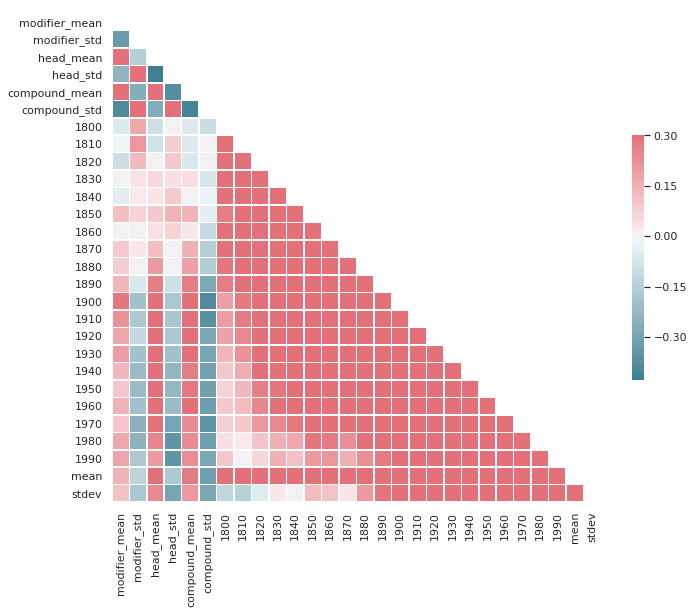

In [73]:
corr=corr_sim_modifier.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [74]:
sim_with_head_df.replace([np.inf, -np.inf], np.nan,inplace=True)
sim_with_head_df['mean']=sim_with_head_df.mean(axis=1)
sim_with_head_df['stdev']=sim_with_head_df.std(axis=1)
corr_sim_head=reddy11_study.merge(sim_with_head_df.reset_index(),on=['modifier','head'],how='right')
corr_sim_head.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_sim_head.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,0.000,0.000,0.000,0.000,...,0.000,0.000,0.112,0.386,0.162,0.748,0.816,0.697,0.146,0.271
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,0.000,0.000,0.000,0.000,...,0.608,0.377,0.412,0.284,0.247,0.171,0.172,0.057,0.150,0.202
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.624,0.689,0.690,0.646,0.132,0.265
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,0.000,0.000,0.000,0.000,...,0.575,0.600,0.669,0.698,0.672,0.712,0.729,0.605,0.387,0.319
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,0.995,0.000,0.000,0.000,...,0.116,0.050,0.047,0.083,0.324,0.183,0.343,0.917,0.161,0.283
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,0.000,0.000,0.000,0.000,...,0.062,0.107,0.094,0.121,0.091,0.094,0.107,0.095,0.044,0.047
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.176,0.186,0.120,0.024,0.059
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.066,0.075,0.069,0.011,0.025
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,0.972,0.990,0.972,0.959,...,0.989,0.989,0.989,0.983,0.980,0.977,0.975,0.958,0.977,0.009


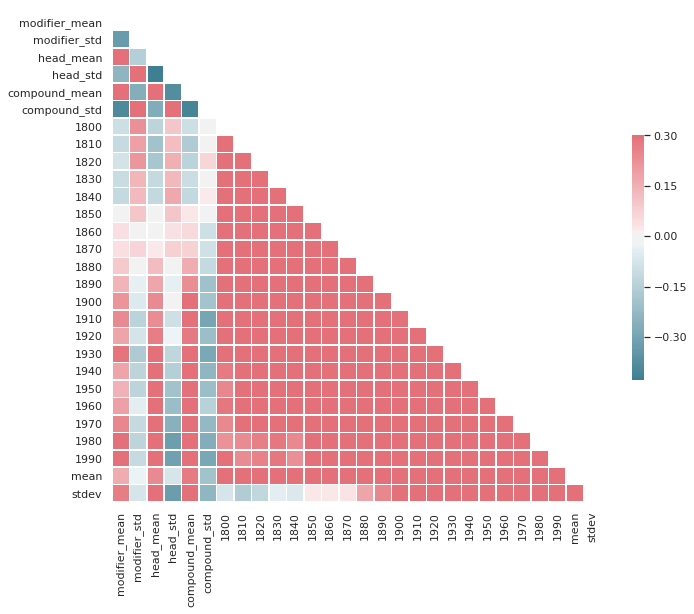

In [75]:
corr=corr_sim_head.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [83]:
count_df_change.replace([np.inf, -np.inf], np.nan,inplace=True)
count_df_change['mean']=count_df_change.mean(axis=1)
count_df_change['stdev']=count_df_change.std(axis=1)
corr_count_df_change=reddy11_study.merge(count_df_change.reset_index(),on=['modifier','head'],how='right')
corr_count_df_change.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_count_df_change.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1930,1940,1950,1960,1970,1980,1990,2000,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,nan,nan,nan,nan,...,nan,nan,"1,022.222",126.733,644.105,869.542,167.405,129.352,472.684,345.601
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,nan,nan,nan,nan,...,-15.789,13.750,-21.978,302.817,71.329,27.959,7.496,14.688,56.118,89.234
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,nan,nan,nan,nan,...,nan,nan,nan,nan,"2,093.750",184.425,148.314,108.377,660.420,756.005
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,nan,nan,nan,nan,...,43.783,147.503,102.657,73.458,84.908,61.304,85.440,12.190,78.176,49.173
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,nan,-100.000,nan,nan,...,-49.412,-23.256,60.606,305.660,309.767,187.628,"10,022.455",431.857,"1,006.003","2,584.132"
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,nan,nan,nan,nan,...,72.222,-34.409,65.574,-31.683,88.406,194.615,90.078,71.703,66.182,61.622
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,57.143,-27.273,100.000,44.211,45.805
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,757.647,90.809,67.865,300.352,277.311
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,nan,171.233,-26.263,95.890,...,-7.282,5.039,6.854,51.312,12.909,41.843,60.298,86.941,38.534,48.998


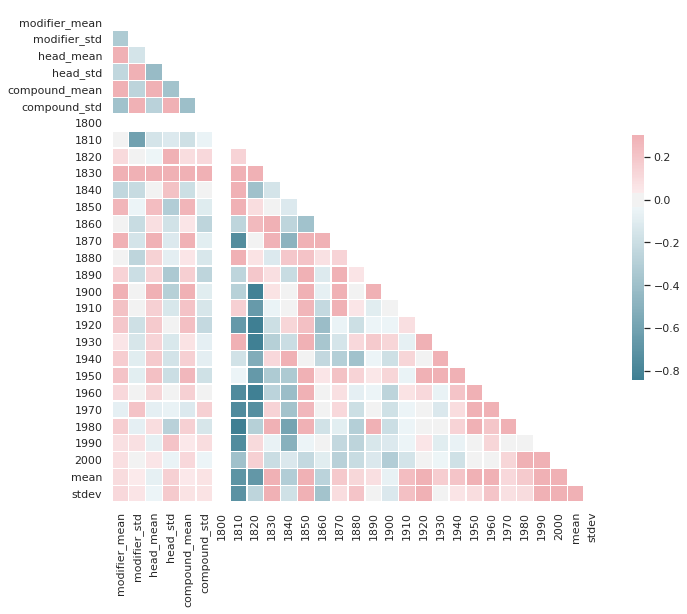

In [84]:
corr=corr_count_df_change.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [85]:
sim_bw_constituents_df.replace([np.inf, -np.inf], np.nan,inplace=True)
sim_bw_constituents_df['mean']=sim_bw_constituents_df.mean(axis=1)
sim_bw_constituents_df['stdev']=sim_bw_constituents_df.std(axis=1)
corr_sim_bw_constituents_df=reddy11_study.merge(sim_bw_constituents_df.reset_index(),on=['modifier','head'],how='right')
corr_sim_bw_constituents_df.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_sim_bw_constituents_df.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,0.000,0.000,0.000,0.000,...,0.000,0.000,0.297,0.304,0.168,0.708,0.735,0.644,0.143,0.251
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,0.000,0.000,0.000,0.000,...,0.263,0.205,0.226,0.237,0.218,0.223,0.192,0.196,0.102,0.106
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.396,0.383,0.472,0.532,0.089,0.180
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,0.000,0.000,0.000,0.000,...,0.532,0.655,0.710,0.737,0.726,0.799,0.834,0.815,0.383,0.335
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,0.835,0.000,0.000,0.000,...,0.014,0.004,0.003,0.590,0.540,0.345,0.322,0.910,0.203,0.301
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,0.000,0.000,0.000,0.000,...,0.027,0.076,0.064,0.102,0.040,0.062,0.096,0.082,0.029,0.036
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.013,0.014,0.005,0.002,0.004
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.153,0.175,0.156,0.024,0.058
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,0.170,0.141,0.086,0.118,...,0.100,0.105,0.122,0.115,0.097,0.125,0.168,0.222,0.133,0.033


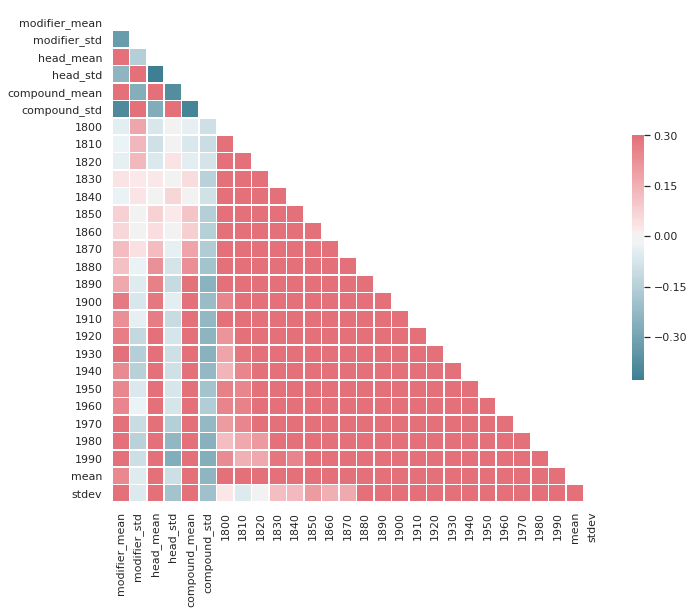

In [86]:
corr=corr_sim_bw_constituents_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [87]:
ppmi_df.replace([np.inf, -np.inf], np.nan,inplace=True)
ppmi_df['mean']=ppmi_df.mean(axis=1)
ppmi_df['stdev']=ppmi_df.std(axis=1)
corr_ppmi_df=reddy11_study.merge(ppmi_df.reset_index(),on=['modifier','head'],how='right')
corr_ppmi_df.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_ppmi_df.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,nan,nan,nan,nan,...,nan,nan,nan,25.503,-22.683,38.140,19.361,-8.140,12.150,20.961
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,nan,nan,nan,nan,...,29.680,-2.926,-8.740,-7.879,39.203,15.940,-5.919,-10.154,8.949,17.326
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,"1,338.309",25.786,-0.088,488.719,546.205
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,nan,nan,nan,nan,...,-5.516,10.545,1.302,-0.130,-3.454,-6.232,-9.978,-7.829,1.006,7.896
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,nan,-100.000,nan,nan,...,49.480,-12.530,-8.571,-0.775,11.236,8.784,0.959,-4.171,-4.533,33.175
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,nan,nan,nan,nan,...,3.900,17.203,-1.021,0.719,-12.946,8.946,4.380,-5.264,4.926,10.089
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,-6.320,-24.237,-9.219,13.604
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,42.797,-0.487,21.277,17.672
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,nan,-3.119,-0.496,0.109,...,1.973,2.534,3.371,0.361,-0.881,1.875,0.286,-4.153,-0.193,2.582


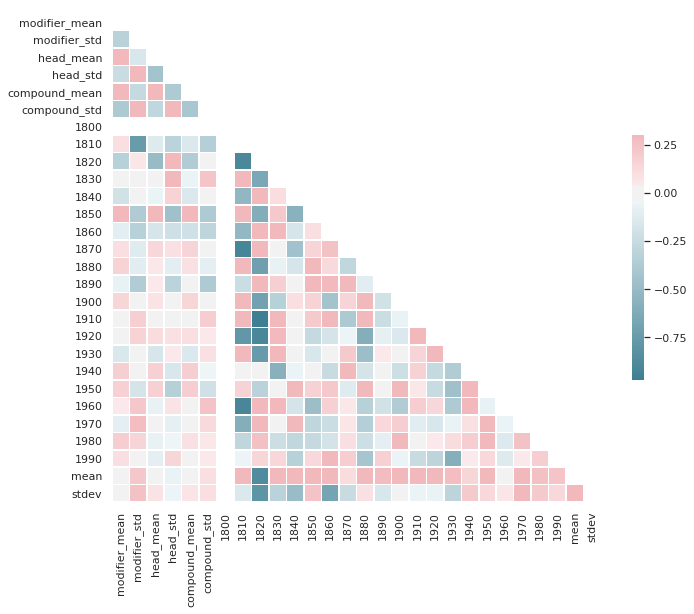

In [88]:
corr=corr_ppmi_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
llr_df.replace([np.inf, -np.inf], np.nan,inplace=True)
llr_df['mean']=llr_df.mean(axis=1)
llr_df['stdev']=llr_df.std(axis=1)
corr_llr_df=reddy11_study.merge(llr_df.reset_index(),on=['modifier','head'],how='right')
corr_llr_df.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_llr_df.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,nan,nan,nan,nan,...,nan,nan,nan,683.855,2.312,876.890,877.726,77.643,503.685,385.885
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,nan,nan,nan,nan,...,64.903,-21.326,-60.160,-64.644,332.661,82.020,-6.893,-31.566,48.686,120.216
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,"203,403.588",211.804,84.600,"67,899.997","95,815.522"
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,nan,nan,nan,nan,...,15.572,62.391,2.087,4.901,5.061,42.378,9.886,23.514,39.329,44.209
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,nan,-100.000,nan,nan,...,610.335,-58.054,-72.368,-18.545,195.196,290.111,132.754,"7,587.230",708.410,"2,083.214"
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,nan,nan,nan,nan,...,42.171,105.255,-73.976,-14.609,-63.614,77.860,147.936,31.773,41.293,74.777
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,14.726,-62.139,-23.707,38.433
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,963.236,40.874,502.055,461.181
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,nan,35.953,-56.096,33.796,...,22.767,-6.818,-56.404,-45.955,-5.186,-3.139,11.447,11.108,2.929,35.805


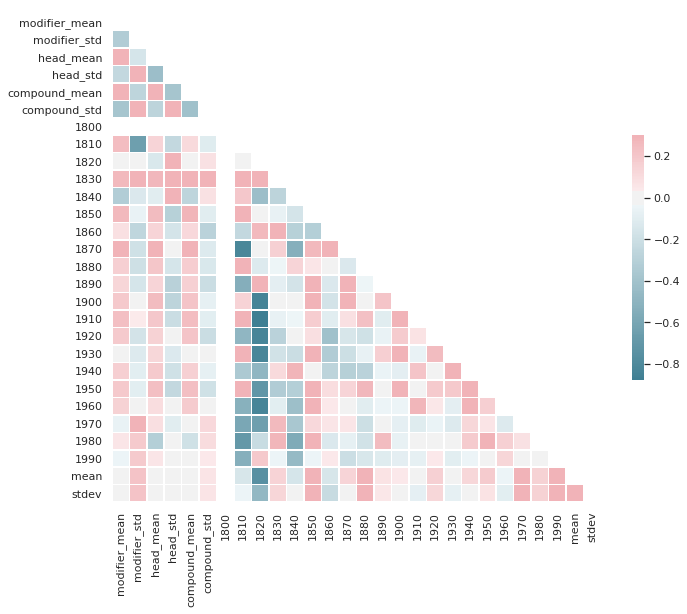

In [36]:
corr=corr_llr_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
lmi_df.replace([np.inf, -np.inf], np.nan,inplace=True)
lmi_df['mean']=lmi_df.mean(axis=1)
lmi_df['stdev']=lmi_df.std(axis=1)
corr_lmi_df=reddy11_study.merge(lmi_df.reset_index(),on=['modifier','head'],how='right')
corr_lmi_df.set_index(['modifier','head'],inplace=True)
#corr_sim_modifier.dropna(inplace=True)
corr_lmi_df.head(10)

,,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,1800,1810,1820,1830,...,1920,1930,1940,1950,1960,1970,1980,1990,mean,stdev
modifier,head,,,,,,,,,,,,,,,,,,,,,
end_n,user_n,3.867,1.118,4.867,0.340,4.250,0.871,nan,-8.720,-24.474,-12.063,...,87.739,-2.386,-28.669,-7.708,4.434,41.469,250.676,58.721,15.185,63.867
firing_n,line_n,1.607,1.655,1.893,1.496,1.704,1.717,nan,-8.720,-24.474,-12.063,...,83.615,-3.518,-30.809,-13.077,7.395,7.341,17.202,4.216,-1.904,26.641
game_n,plan_n,2.821,1.965,4.862,0.345,3.828,1.234,nan,-8.720,-24.474,-12.063,...,87.739,-2.386,-29.091,-11.559,4.338,20.353,39.615,24.507,0.934,29.504
application_n,form_n,4.767,0.423,4.862,0.345,4.800,0.476,nan,-8.720,-24.474,-12.063,...,41.039,29.624,-14.052,1.321,3.148,34.565,14.480,18.782,6.819,24.270
web_n,site_n,2.679,1.691,3.933,1.181,3.786,1.206,nan,-47.501,-24.474,-12.063,...,111.864,-11.198,-32.632,-11.706,9.317,24.499,42.605,"2,394.289",125.145,536.007
grandfather_n,clock_n,0.429,0.776,5.000,0.000,2.643,1.315,nan,-8.720,-24.474,-12.063,...,80.192,9.517,-39.114,-11.633,-1.467,6.893,24.881,8.286,-1.276,26.862
diamond_n,wedding_n,1.067,1.289,3.407,1.341,1.704,1.048,nan,-8.720,-24.474,-12.063,...,87.739,-2.386,-29.091,-11.559,4.276,5.228,18.773,5.884,-1.942,27.448
guilt_n,trip_n,4.714,0.589,0.862,0.937,2.185,1.156,nan,-8.720,-24.474,-12.063,...,87.739,-2.386,-29.091,-11.559,4.276,6.831,34.540,10.051,-0.809,28.377
silver_n,spoon_n,1.593,1.472,1.444,1.771,1.519,1.450,nan,17.033,-44.260,18.182,...,28.819,-6.070,-53.562,-34.154,-3.079,-0.389,14.594,7.974,-0.625,25.799


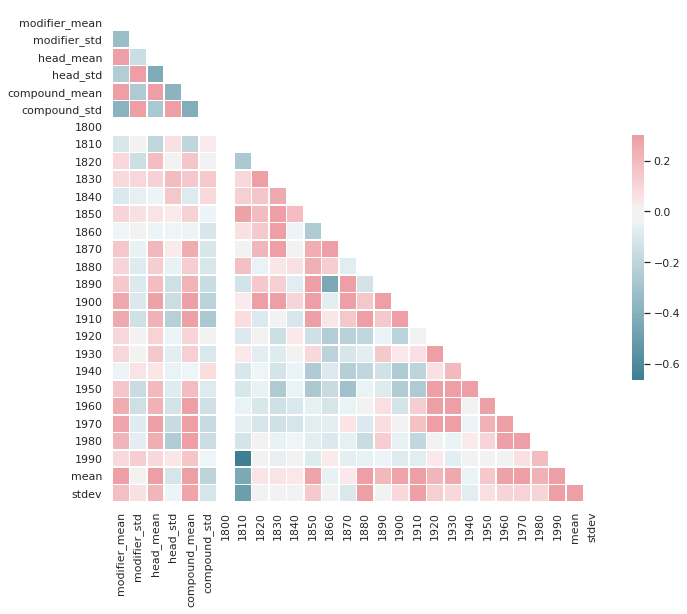

In [38]:
corr=corr_lmi_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

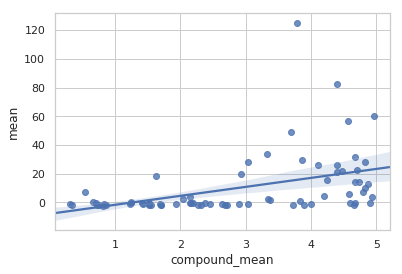

In [39]:
ax = sns.regplot(x="compound_mean", y="mean", data=corr_lmi_df)

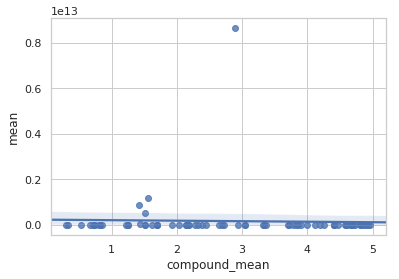

In [40]:
ax = sns.regplot(x="compound_mean", y="mean", data=corr_llr_df)

In [95]:
ax = sns.regplot(x="compound_mean", y=1990, data=corr_sim_bw_constituents_df)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

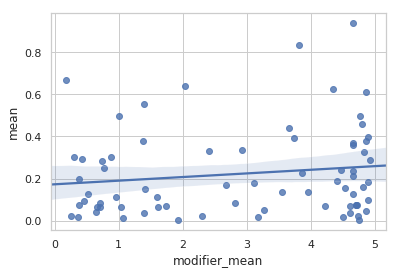

In [93]:
ax = sns.regplot(x="modifier_mean", y="mean", data=corr_sim_modifier)
#ax.set_yscale('log')

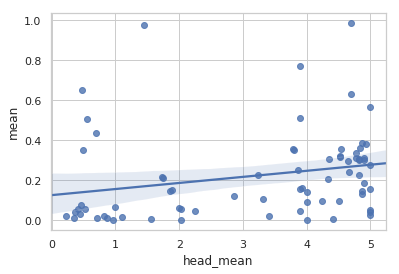

In [92]:
ax = sns.regplot(x="head_mean", y="mean", data=corr_sim_head)

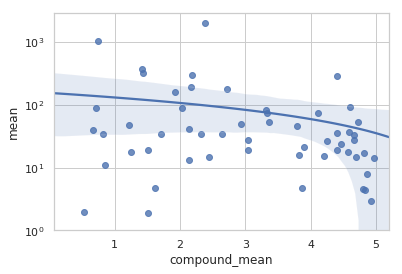

In [58]:
ax = sns.regplot(x="compound_mean", y="mean", data=corr_sim_modifier)
ax.set_yscale('log')

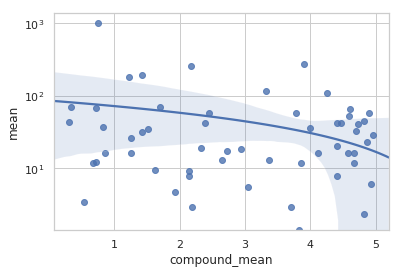

In [59]:
ax = sns.regplot(x="compound_mean", y="mean", data=corr_sim_head)
ax.set_yscale('log')